# Testing a model

This notebook loads a trained XGBoost model and the test set and measures the accuracy of the XGBoost model. Predictions on experimental PDFs can also be made here.

**How to use:** Run the cells underneath from top to bottom 

The first cell imports packages and functions from the backend. The next cells loads the PDF dataset and the XGBoost model. Then, the XGBoost model is tested on the PDF test set.
Lastly, an experimental PDF can be loaded and the XGBoost model can predict its structure. The results from the prediction is then saved in the results folder.

# Import packages and functions from backend

In [1]:
import sys, os, os.path, h5py, time, shutil

from os import walk
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score
from scipy.optimize.minpack import leastsq
from diffpy.Structure import loadStructure
from diffpy.srfit.pdf import PDFContribution
from diffpy.srfit.fitbase import FitRecipe, FitResults

from shutil import copy

sys.path.append("Backend")

from testing import sort_filenames, get_testing_backend, load_PDFs, test_model, load_exp_pdf, plot_PDF, plot_loaded_PDF, model_predict_cluster, fitPDF
sorted_filenames_flat, xyz_path = get_testing_backend(xyz_folder_name = "natoms200")

# Import PDF dataset

Load PDF dataset from the folder "/PDF_datasets/". Specify the folder name of the dataset you want to load and train a model on.

In [4]:
folder_name = "medium"

X_train, y_train, X_val, y_val, X_test, y_test = load_PDFs(folder_name)
display(X_test)
display(y_test)

,1,2,3,4,5,6,7,8,9,10,...,294,295,296,297,298,299,300,qmin,qmax,qdamp
0,0.0,0.012032,-0.003895,-0.024536,-0.016968,-0.000371,-0.012115,-0.036865,-0.033264,-0.012749,...,0.016220,0.016312,0.015747,0.015564,0.015991,0.016083,0.015472,0.394775,15.171875,0.023987
1,0.0,0.010765,0.020844,0.032043,0.036682,0.048157,0.047363,0.049255,0.052948,0.040039,...,0.002045,0.000378,0.003843,0.001060,0.001896,0.002941,0.000395,1.990234,24.609375,0.020218
2,0.0,0.005630,-0.003746,-0.003963,0.007217,-0.001245,-0.007858,0.009148,0.001906,-0.012970,...,0.000635,0.002831,-0.003622,0.000138,0.003304,-0.003265,-0.000439,0.012207,20.562500,0.013985
3,0.0,-0.013344,-0.018600,-0.033661,-0.045532,-0.050354,-0.066101,-0.076477,-0.081604,-0.097534,...,-0.009827,-0.010406,-0.011070,-0.011551,-0.011955,-0.012421,-0.012688,0.692383,21.687500,0.026123
4,0.0,0.013771,0.036896,0.053131,0.059509,0.072937,0.086670,0.084106,0.079468,0.084473,...,-0.003469,-0.000917,-0.000407,-0.002306,-0.001318,0.001284,0.000583,1.987305,17.250000,0.018494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3738,0.0,-0.009857,-0.016296,-0.025299,-0.036163,-0.042114,-0.050293,-0.062744,-0.067505,-0.074402,...,0.000847,-0.000035,-0.000046,0.000896,-0.000095,-0.000002,0.001027,0.894531,21.093750,0.012627
3739,0.0,-0.007160,-0.007114,-0.016006,-0.022079,-0.022125,-0.032227,-0.037567,-0.038879,-0.049988,...,-0.002180,-0.002224,-0.001669,-0.001494,-0.001412,-0.000786,-0.000607,1.310547,21.718750,0.011871
3740,0.0,0.000799,-0.012848,-0.012772,-0.010590,-0.024765,-0.025848,-0.021255,-0.035645,-0.039124,...,-0.008339,-0.009079,-0.008057,-0.007866,-0.008591,-0.007580,-0.007236,0.381836,20.375000,0.012878
3741,0.0,0.000095,-0.001597,-0.002569,-0.001610,-0.002871,-0.005085,-0.003429,-0.003975,-0.007797,...,-0.018875,-0.019104,-0.017960,-0.017090,-0.017319,-0.016327,-0.015358,0.136353,20.234375,0.011292


0          0.0
1          1.0
2          2.0
3          3.0
4          4.0
         ...  
3738    3738.0
3739    3739.0
3740    3740.0
3741    3741.0
3742    3742.0
Name: filename, Length: 3743, dtype: float64

# Load XGBoost model

Specify the name name of the XGBoost model. The same as the folder_name in 2_Training.ipynb.

In [2]:
model_name = "big" #medium er en tester. big er 100_15 modellen, den jeg afleverede i mit bsc projekt

model_trained = xgb.Booster({'nthread': 4})
model_trained.load_model("Models/XGBmodel_" + model_name + ".model")

# Test XGBoost model on the PDF test set

Tests the XGBoost model on the PDF test set and gives the accuracies in the models best prediction, as well as the models best 3 and best 5 predictions.

In [5]:
test_model(X_test, y_test, model_trained)

Percent guessed structures in test set: 0.240 %
Percent guessed structures in top3 in test set: 0.454 %
Percent guessed structures in top5 in test set: 0.748 %
Time spent on predicting with model: 1.4255  min


# Load experimental PDF

Shows the PDFs in the folder "ExperimentalData/". Set exp_filename to the desired filename and load the desired experimental PDF.

In [6]:
print(os.listdir("ExperimentalData"))

['Au144PET_100K-00000.gr', 'Au146pMBA.gr', 'Cleaned', 'JQ_S3_Pt_FCC.gr']


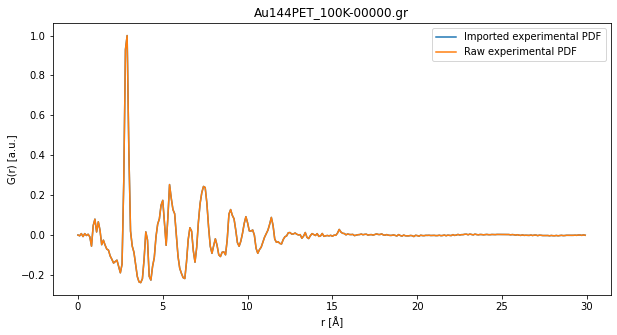

In [7]:
exp_filename = "Au144PET_100K-00000.gr"
xgrid, xyz_pdf, xyz_pdf_raw = load_exp_pdf(exp_filename)
plot_loaded_PDF(xgrid, xyz_pdf, xyz_pdf_raw, exp_filename)

# Predict on experimental PDF with XGBoost model

Predicts the structure of an experimental PDF. The XGBoost model predicts on the PDF as well as the Qmin, Qmax and Qdamp. Therefore, enter these values for your specific experimental PDF in the cell below. The next cell predicts with the XGBoost model, fits simulated PDFs from the top 3 predictions to the experimental PDF, plots it and saves the results and the plot to "Results/"

In [7]:
Qmin = 1.0   #Insert Qmin yourself
Qmax = 22    #Insert Qmax yourself
Qdamp = 0.03 #Insert Qdamp yourself - Standard Qdamp is: 0.03

The model was given cluster: Au144PET_100K-00000.gr
The model predicts the following:
Guess 1 with 87.2 % is: Decahedron_p_4_q_1_r_1_atom_Tc_lc_2.54.xyz
Guess 2 with 1.28 % is: HCP_Size1_1_Size2_3_Size3_9_atom_Cr_lc1_2.38_lc2_3.8865399999999997.xyz
Guess 3 with 1.24 % is: Decahedron_p_3_q_4_r_0_atom_V_lc_2.44.xyz
Guess 4 with 1.09 % is: HCP_Size1_1_Size2_2_Size3_10_atom_Hg_lc1_2.78_lc2_4.53974.xyz
Guess 5 with 0.74 % is: Icosahedron_shell_4_atom_Cr_lc_2.38.xyz
The five predicted clusters have been saved to Results/Au144PET_100K-00000/


/home/marcusnweng/anaconda3/envs/diffpy/lib/python3.7/site-packages/scipy/optimize/minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 400.
  warnings.warn(errors[info][0], RuntimeWarning)



Fit parameters for: Decahedron_p_4_q_1_r_1_atom_Tc_lc_2.54.xyz
scale: 0.09422691740504874
M_Biso: 0.6328988671551159
Lat: 1.1186258588012408

Fit parameters for: HCP_Size1_1_Size2_3_Size3_9_atom_Cr_lc1_2.38_lc2_3.8865399999999997.xyz
scale: 0.20897294418426812
M_Biso: 0.5056309736103937
Lat: 1.2058259069357171

Fit parameters for: Decahedron_p_3_q_4_r_0_atom_V_lc_2.44.xyz
scale: 0.12118065192328667
M_Biso: 0.5758828005626787
Lat: 1.1672258108605487


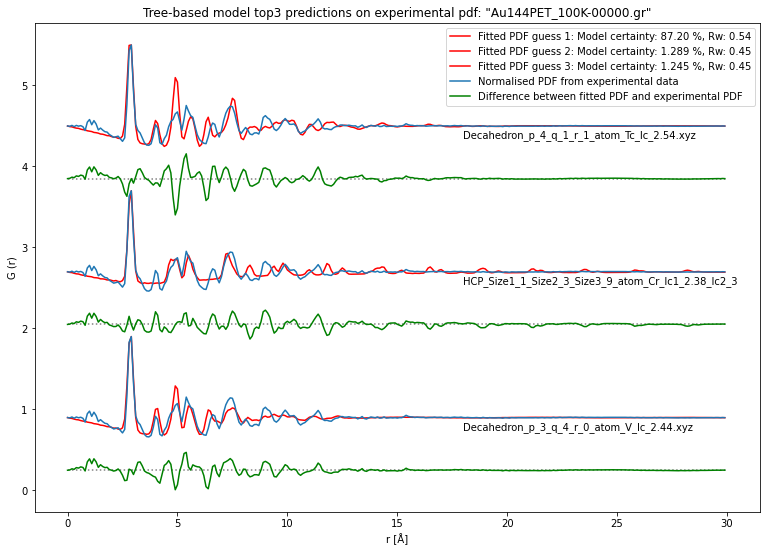

In [8]:
indexn_list, guess_filenames, top5list = model_predict_cluster(xyz_path, xyz_pdf, exp_filename, model_trained, sorted_filenames_flat, Qmin, Qmax, Qdamp)

gcalc1, rw1 = fitPDF(guess_filenames[0], exp_filename, xyz_path, Qmin, Qmax, Qdamp)
gcalc2, rw2 = fitPDF(guess_filenames[1], exp_filename, xyz_path, Qmin, Qmax, Qdamp)
gcalc3, rw3 = fitPDF(guess_filenames[2], exp_filename, xyz_path, Qmin, Qmax, Qdamp)

plot_PDF(xgrid, xyz_pdf, exp_filename, indexn_list, top5list, guess_filenames, gcalc1, gcalc2, gcalc3, rw1, rw2, rw3)